In [1]:
!pip install torch torchvision tqdm

In [2]:
import torch
import torchvision.utils as vutils
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
torch.manual_seed(123)

/home/la9631/miniconda3/envs/firstenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load MNIST dataset as tensors using DataLoader class
batch_size = 256
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

def tensor_to_images(image_tensor, num_images=20, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [4]:
sample_img = next(iter(dataloader))

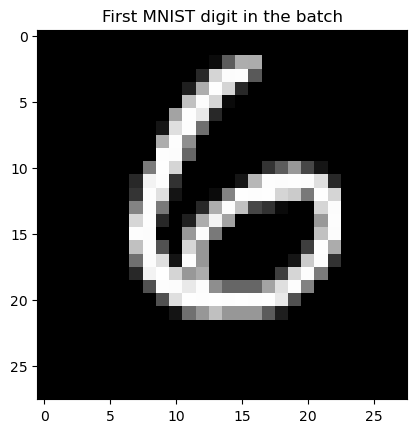

torch.Size([256, 1, 28, 28])

In [5]:
plt.imshow(sample_img[0][0].squeeze(), cmap="gray")
plt.title("First MNIST digit in the batch")
plt.show()
sample_img[0].shape

In [6]:
sample_img[-1][0:30]

tensor([6, 8, 4, 8, 2, 8, 0, 6, 6, 0, 9, 5, 2, 7, 1, 8, 1, 1, 4, 6, 1, 2, 6, 0,
        7, 5, 3, 4, 8, 9])

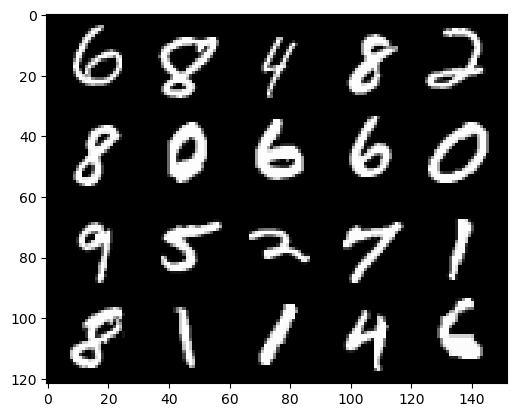

In [7]:
tensor_to_images(sample_img[0])

In [8]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=12, image_dimension=784, hidden_dimension=128):
        super(Generator, self).__init__()

        self.n_dim = noise_dimension
        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        # Build the generator network
        self.gen = nn.Sequential(
            self.generator_block(self.n_dim, self.h_dim),
            self.generator_block(self.h_dim, self.h_dim * 2),
            self.generator_block(self.h_dim * 2, self.h_dim * 4),
            self.generator_block(self.h_dim * 4, self.h_dim * 8),
            nn.Linear(self.h_dim * 8, self.im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    def generator_block(self, in_dimension, out_dimension):
        return nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.BatchNorm1d(out_dimension),
            nn.ReLU(inplace=True),
        )

In [9]:
def get_noise(n_samples, noise_vector_dimension, device='cpu'):
    return torch.randn(n_samples, noise_vector_dimension,device=device)

In [10]:
torch.rand(5, 6, device = 'cpu')

tensor([[0.0740, 0.8665, 0.1366, 0.1025, 0.1841, 0.7264],
        [0.3153, 0.6871, 0.0756, 0.1966, 0.3164, 0.4017],
        [0.1186, 0.8274, 0.3821, 0.6605, 0.8536, 0.5932],
        [0.6367, 0.9826, 0.2745, 0.6584, 0.2775, 0.8573],
        [0.8993, 0.0390, 0.9268, 0.7388, 0.7179, 0.7058]])

In [11]:
class Discriminator(nn.Module):
    def __init__(self, image_dimension=784, hidden_dimension=128):
        super(Discriminator, self).__init__()

        self.im_dim = image_dimension
        self.h_dim = hidden_dimension

        self.disc = nn.Sequential(
            self.discriminator_block(self.im_dim, self.h_dim * 4),
            self.discriminator_block(self.h_dim * 4, self.h_dim * 2),
            self.discriminator_block(self.h_dim * 2, self.h_dim),
            nn.Linear(self.h_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def discriminator_block(self, in_dimension, out_dimension):
      return nn.Sequential(
           nn.Linear(in_dimension, out_dimension),
           nn.LeakyReLU(0.2, inplace=True)
      )

In [12]:
# Hyperparameters for training loop
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
noise_dimension = 64
display_step = 10000
lr = 0.00001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
gen = Generator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [14]:
print(disc)

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [15]:
def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # All of them will got label as 0
    # .detach() here is to ensure that only discriminator parameters will get update
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred,
                               torch.zeros_like(disc_fake_pred))

    # Pass real features to discriminator
    # All of them will got label as 1
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred,
                               torch.ones_like(disc_real_pred))

    # Average of loss from both real and fake features
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
    # Generate noise and pass to generator
    fake_noise = get_noise(num_images, noise_dimension, device=device)
    fake = gen(fake_noise)

    # Pass fake features to discriminator
    # But all of them will got label as 1
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

100%|██████████| 235/235 [00:02<00:00, 89.61it/s]


Visualizing Generator output at Epoch 10


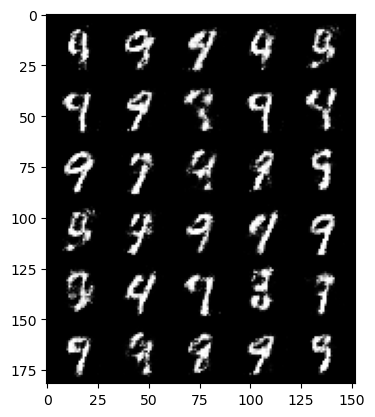

100%|██████████| 235/235 [00:02<00:00, 83.68it/s]


Visualizing Generator output at Epoch 50


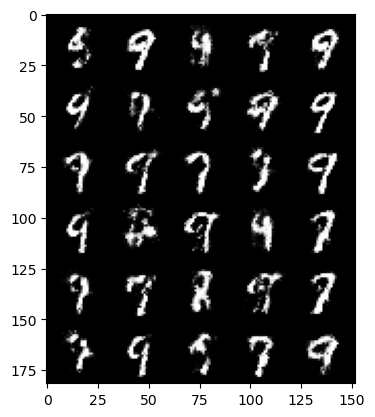

100%|██████████| 235/235 [00:02<00:00, 82.76it/s]


Visualizing Generator output at Epoch 100


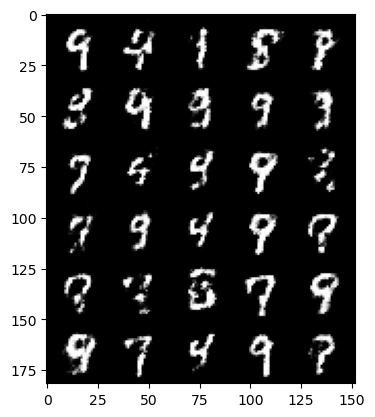

In [16]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # Get number of batch size (number of image)
        # And get tensor for each image in batch
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Traing discriminator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_disc_loss()
        # Update gradient .gradient()
        # Update optimizer .step()
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        ### Traing generator ###
        # Zero out the gradient .zero_grad()
        # Calculate discriminator loss get_gen_loss()
        # Update gradient .gradient()
        # Update optimizer .step()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
    
# Lists to store losses for visualization later
# Initialize loss storage lists before the training loop

# Initialize lists for storing epoch-level loss values
gen_epoch_losses = []
disc_epoch_losses = []
epochs_list = []

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

for epoch in range(1, n_epochs + 1):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        ### Train Discriminator ###
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, noise_dimension, device=device)
        fake = gen(fake_noise)

        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward()
        disc_opt.step()

        ### Train Generator ###
        gen_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, noise_dimension, device=device)
        fake = gen(fake_noise)
        
        disc_fake_pred = disc(fake)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item()
        mean_generator_loss += gen_loss.item()

    # Calculate mean losses for the epoch
    mean_gen_loss_epoch = mean_generator_loss / len(dataloader)
    mean_disc_loss_epoch = mean_discriminator_loss / len(dataloader)

    gen_epoch_losses.append(mean_gen_loss_epoch)
    disc_epoch_losses.append(mean_disc_loss_epoch)
    epochs_list.append(epoch)

    # Reset mean losses for the next epoch
    mean_generator_loss = 0
    mean_discriminator_loss = 0

    # Visualize generator output at specific epochs (10, 50, 100)
    if epoch in [10, 50, 100]:
        print(f"Visualizing Generator output at Epoch {epoch}")
        fake_images = gen(get_noise(30, noise_dimension, device=device))
        tensor_to_images(fake_images, num_images=30)
        vutils.save_image(fake_images.view(-1, 1, 28, 28), f'generated_epoch_{epoch}.png', nrow=5, normalize=True)


# Save the loss values to a CSV file
loss_df = pd.DataFrame({
    'Epoch': epochs_list,
    'Generator Loss': gen_epoch_losses,
    'Discriminator Loss': disc_epoch_losses
})

loss_df.to_csv('gan_loss_values.csv', index=False)


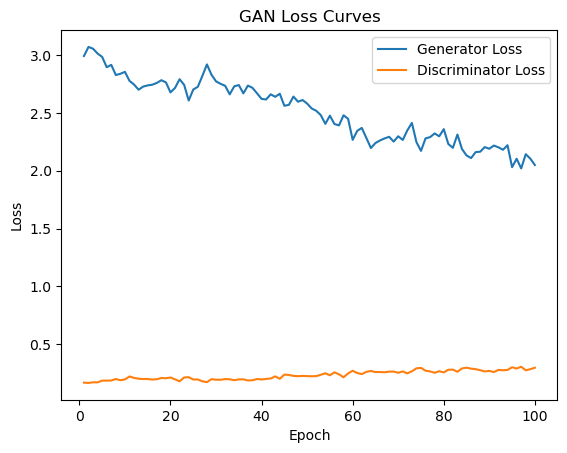

In [18]:
loss_df = pd.read_csv('gan_loss_values.csv')

# Plot the loss curves
plt.plot(loss_df['Epoch'], loss_df['Generator Loss'], label="Generator Loss")
plt.plot(loss_df['Epoch'], loss_df['Discriminator Loss'], label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Loss Curves')
plt.legend()
plt.show()